In [0]:
#import dependencies
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
%matplotlib inline

In [0]:
# read diamonds.csv file into spark dataframe
diamonds_df = spark.read.csv("dbfs:/FileStore/tables/diamonds.csv", header=True, inferSchema=True)

In [0]:
#display top records
display(diamonds_df.toPandas().head())

_c0,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [0]:
import pyspark.sql.functions as F
diamonds_df = diamonds_df.drop(F.col("_c0")) # remove duplicate index column
display(diamonds_df.toPandas().head())

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [0]:
# convert structure fields (columns) to appropriate dataType(s)
from pyspark.sql.types import DoubleType, IntegerType
diamonds_df = diamonds_df.withColumn("carat", diamonds_df["carat"].cast(DoubleType())).withColumn("depth", diamonds_df["depth"].cast(DoubleType()))\
         .withColumn("table", diamonds_df["table"].cast(DoubleType())).withColumn("price", diamonds_df["price"].cast(DoubleType()))\
         .withColumn("x", diamonds_df["x"].cast(DoubleType())).withColumn("y", diamonds_df["y"].cast(DoubleType()))\
         .withColumn("z", diamonds_df["z"].cast(DoubleType()))
# get data types
diamonds_df.dtypes

Out[15]: [('carat', 'double'),
 ('cut', 'string'),
 ('color', 'string'),
 ('clarity', 'string'),
 ('depth', 'double'),
 ('table', 'double'),
 ('price', 'double'),
 ('x', 'double'),
 ('y', 'double'),
 ('z', 'double')]

Out[16]:

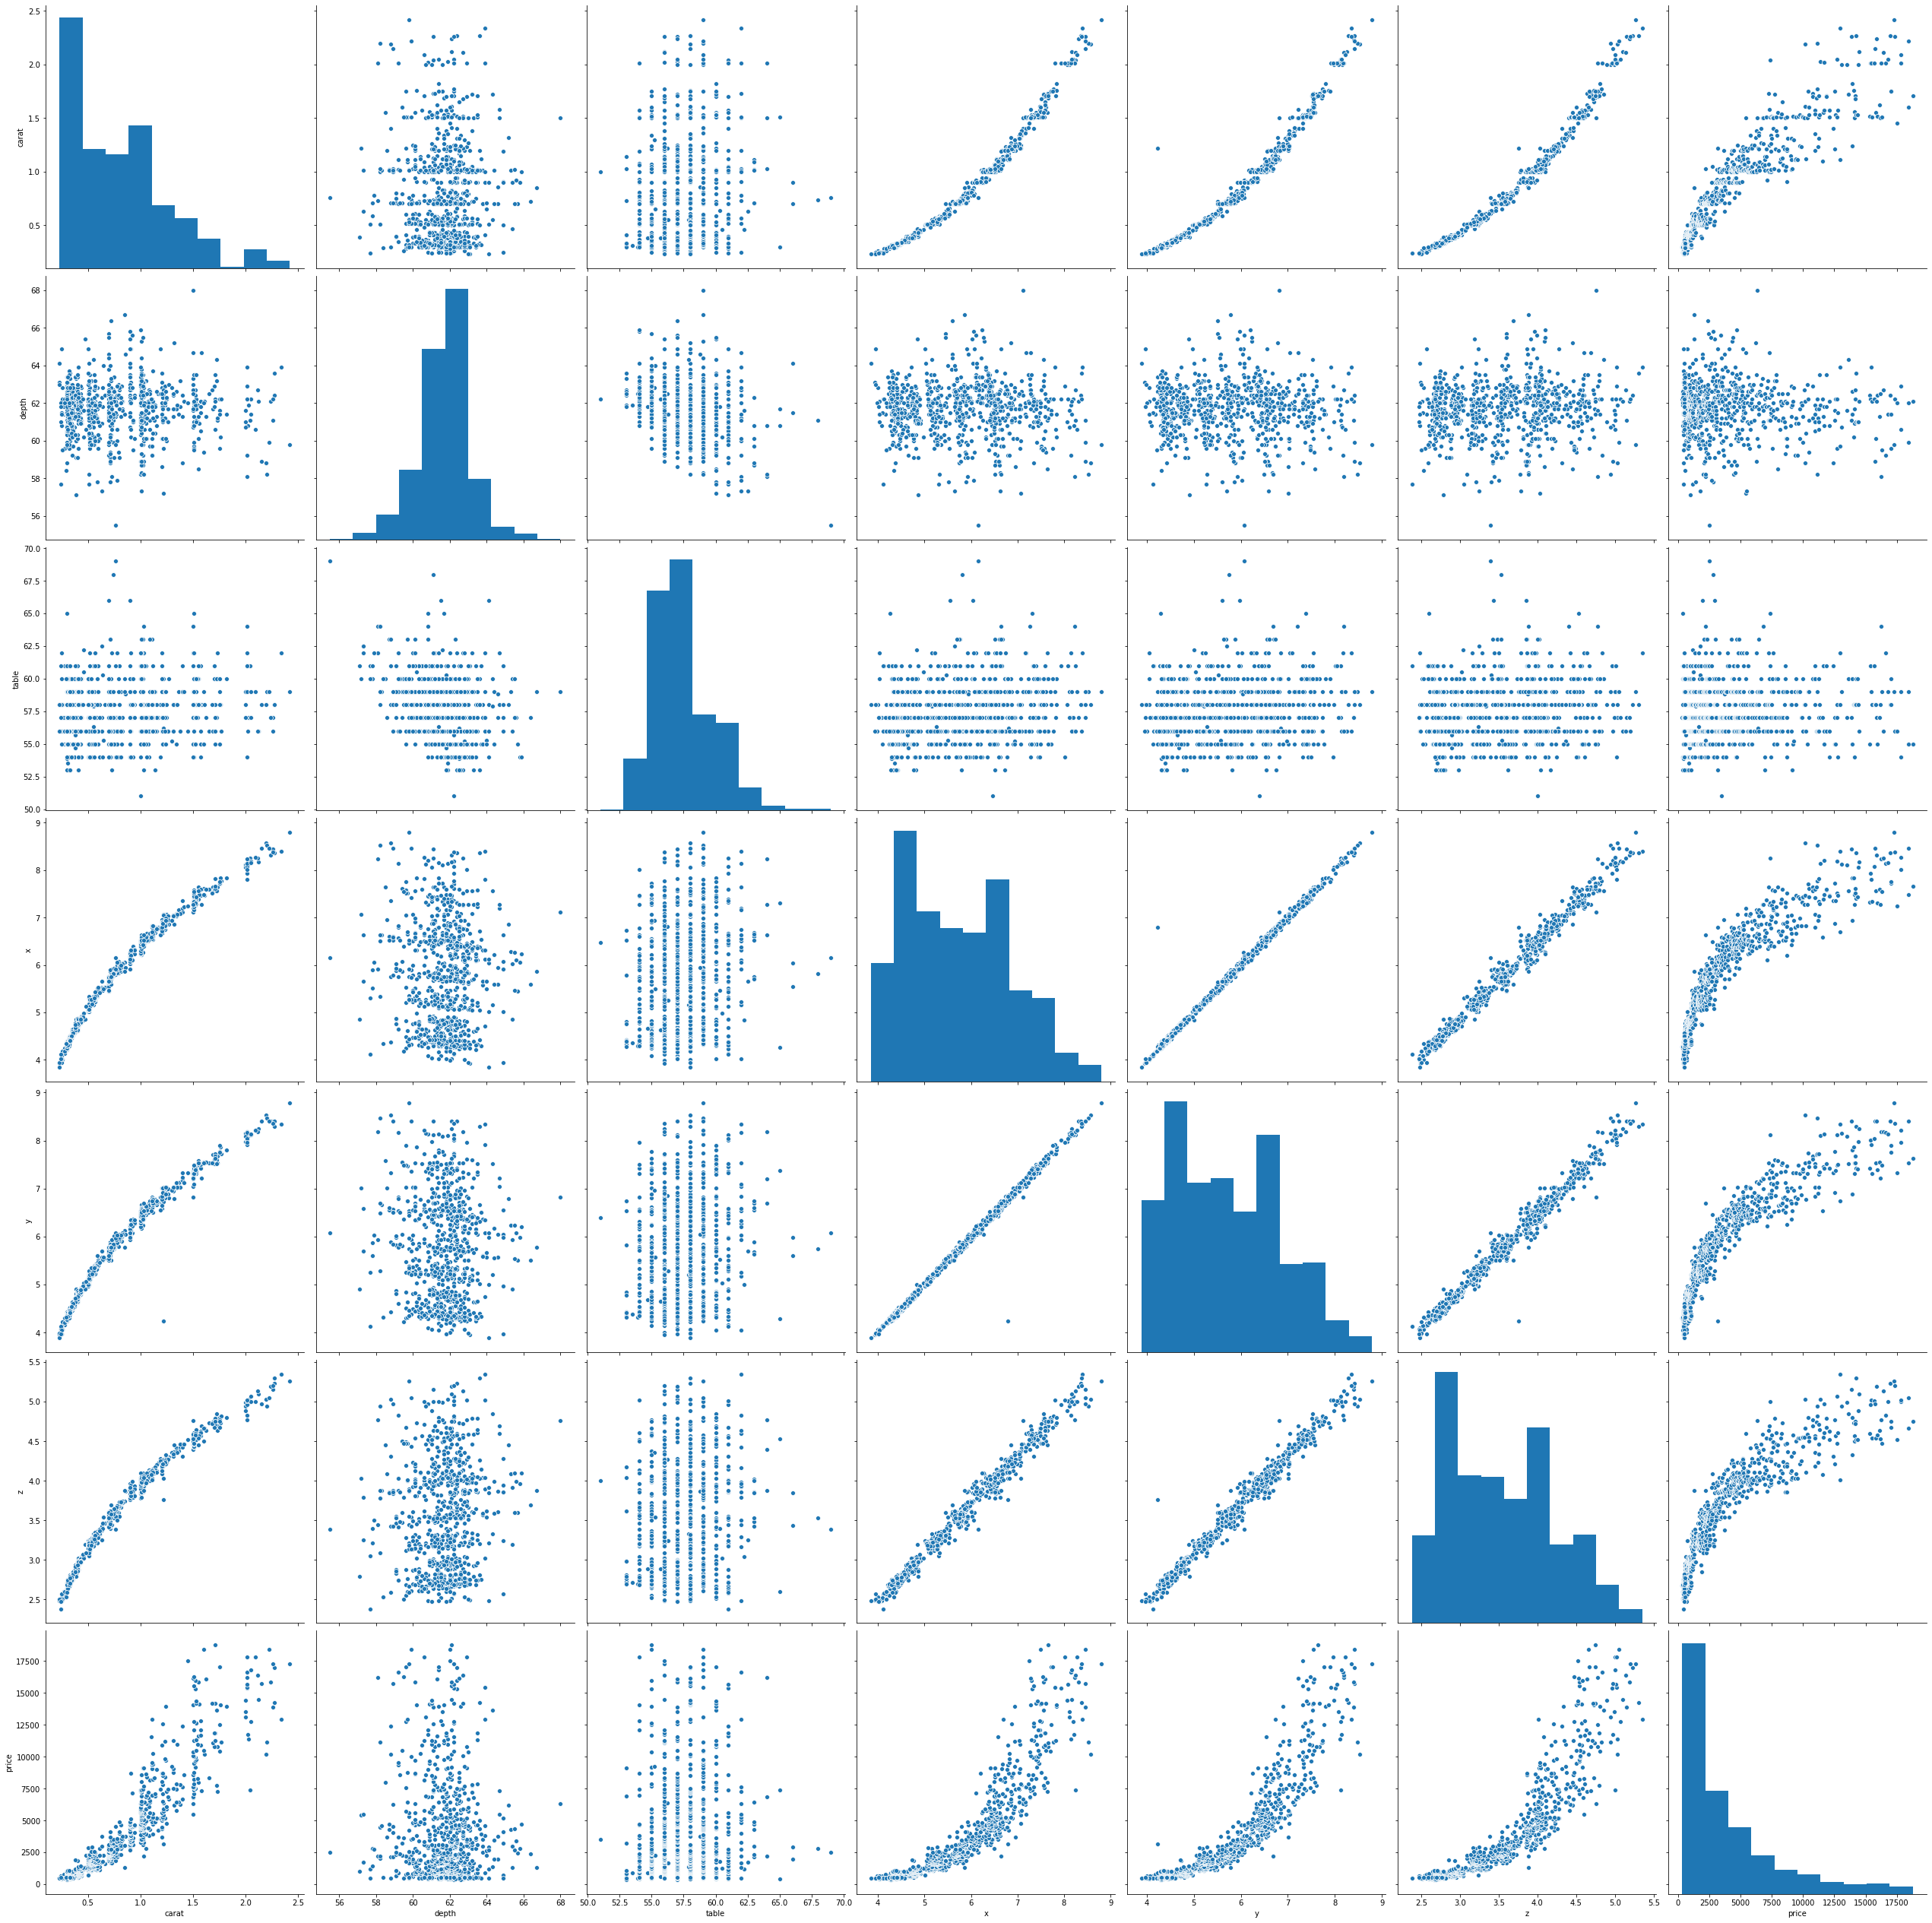

<seaborn.axisgrid.PairGrid at 0x7f7af3555e90>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
# large file, sample 1% - 2% before plotting pairplot
# 0.015% of (53,000 rows) is sufficient to just get a general peek at the data
pdf_diamonds = diamonds_df.select("carat", "depth","table" ,"x","y","z","price").sample(fraction=0.015, seed=28).toPandas() 
sns.pairplot(pdf_diamonds, height=5)

In [0]:
#get statistical summary of the data
diamonds_df.describe().show() 

+-------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
summary| carat| cut|color|clarity| depth| table| price| x| y| z|
+-------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
 count| 53940| 53940|53940| 53940| 53940| 53940| 53940| 53940| 53940| 53940|
 mean|0.7979397478679852| null| null| null| 61.74940489432624| 57.45718390804603|3932.799721913237| 5.731157211716609| 5.734525954764462|3.5387337782723316|
 stddev|0.4740112444054196| null| null| null|1.4326213188336525|2.2344905628213247|3989.439738146397|1.1217607467924915|1.1421346741235616|0.7056988469499883|
 min| 0.2| Fair| D| I1| 43.0| 43.0| 326.0| 0.0| 0.0| 0.0|
 max| 5.01|Very Good| J| VVS2| 79.0| 95.0| 18823.0| 10.74| 58.9| 31.8|
+-------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+

Pair plot :

Upon vizualizing the data, we observe that the target variable (price) is not normally distributed (right skew) We inpected the r/ships of all variables with target column, price, and found that carat had an almost linear r/ship with price. Variables like table and depth had no linear pattern with price variable, however, their histogram plot (table and depth) was somewhat normal. We also observed that as price increases, y and z tend to increase initially and then start to flatten off at higher values (generating a curve like scatter plot) We also observed that x,y and z have some kind of correlation going on with their plots.

Statistical summary observations :

No missing values in data set Price has many outliers and this is expected from the skewed histogram plot in the pair plot All other variables don't have major outliers like price.

In [0]:
#get distinct values of cut
diamonds_df.select("cut").distinct().show()

+---------+
 cut|
+---------+
 Premium|
 Ideal|
 Good|
 Fair|
Very Good|
+---------+

In [0]:
#get distinct values of color
diamonds_df.select("color").distinct().show()

+-----+
color|
+-----+
 F|
 E|
 D|
 J|
 G|
 I|
 H|
+-----+

In [0]:
#get distinct values of clarity
diamonds_df.select("clarity").distinct().show()

+-------+
clarity|
+-------+
 VVS2|
 SI1|
 IF|
 I1|
 VVS1|
 VS2|
 SI2|
 VS1|
+-------+

In [0]:
# import libraries and dependencies
from pyspark.ml.pipeline import Transformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import  VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import  StringType
from pyspark.ml.evaluation import RegressionEvaluator

# create custom functions for use in pipeline
# cut encoder
class encodeCut(Transformer):
  # diamond cut extractor herit of property of Transformer 
  def __init__(self, inputCol, outputCol='cut'):
      self.inputCol = inputCol #the name of columns
      self.outputCol = outputCol #the name of output column
  def this():
      #define an unique ID
      this(Identifiable.randomUID("cutextractor"))
  def copy(extra):
      defaultCopy(extra)
  def check_input_type(self, schema):
      field = schema[self.inputCol]
      #assert that field is a stringtype 
      if (field.dataType != StringType()):
          raise Exception('CutExtractor input type %s did not match input type StingType' % field.dataType)
  def _transform(self, df):
      self.check_input_type(df.schema) 
      return df.withColumn(self.outputCol, F.when((df[self.inputCol] == "Ideal"), 5)
                               .otherwise(F.when((df[self.inputCol] =="Premium"), 4)
                                .otherwise(F.when((df[self.inputCol] == "Very Good"), 3)
                                 .otherwise(F.when((df[self.inputCol] == "Good"), 2)
                                 .otherwise(F.when((df[self.inputCol] == "Fair"), 1))))))           

    


# clarity encoder
class encodeClarity(Transformer):
  # diamond clarity extractor herit of property of Transformer 
  def __init__(self, inputCol, outputCol='clarity'):
      self.inputCol = inputCol #the name of columns
      self.outputCol = outputCol #the name of output column
  def this():
      #define an unique ID
      this(Identifiable.randomUID("clarityextractor"))
  def copy(extra):
      defaultCopy(extra)
  def check_input_type(self, schema):
      field = schema[self.inputCol]
      #assert that field is a stringtype 
      if (field.dataType != StringType()):
          raise Exception('ClarityExtractor input type %s did not match input type StingType' % field.dataType)
  def _transform(self, df):
      self.check_input_type(df.schema) 
      return df.withColumn(self.outputCol, F.when((df[self.inputCol] == "IF"), 8)
                               .otherwise(F.when((df[self.inputCol] =="VVS1"), 7)
                                .otherwise(F.when((df[self.inputCol] == "VVS2"), 6)
                                 .otherwise(F.when((df[self.inputCol] == "VS1"), 5)
                                 .otherwise(F.when((df[self.inputCol] == "VS2"), 4)
                                 .otherwise(F.when((df[self.inputCol] == "SI1"), 3)
                                 .otherwise(F.when((df[self.inputCol] == "SI2"), 2)
                                  .otherwise(F.when((df[self.inputCol] == "I1"), 1)))))))))           

                                             
# color encoder
class encodeColor(Transformer):
  # diamond color extractor herit of property of Transformer 
  def __init__(self, inputCol, outputCol='color'):
      self.inputCol = inputCol #the name of columns
      self.outputCol = outputCol #the name of output column
  def this():
      #define an unique ID
      this(Identifiable.randomUID("colorextractor"))
  def copy(extra):
      defaultCopy(extra)
  def check_input_type(self, schema):
      field = schema[self.inputCol]
      #assert that field is a stringtype 
      if (field.dataType != StringType()):
          raise Exception('ClarityExtractor input type %s did not match input type StingType' % field.dataType)
  def _transform(self, df):
      self.check_input_type(df.schema) 
      return df.withColumn(self.outputCol, F.when((df[self.inputCol] == "D"), 7)
                               .otherwise(F.when((df[self.inputCol] =="E"), 6)
                                .otherwise(F.when((df[self.inputCol] == "F"), 5)
                                 .otherwise(F.when((df[self.inputCol] == "G"), 4)
                                 .otherwise(F.when((df[self.inputCol] == "H"), 3)
                                 .otherwise(F.when((df[self.inputCol] == "I"), 2)
                                 .otherwise(F.when((df[self.inputCol] == "J"), 1))))))))
                                                                               

In [0]:
cut = encodeCut(inputCol="cut") # cut encoder
col = encodeColor(inputCol="color") # color encoder
cla = encodeClarity(inputCol="clarity") # clarity encoder
feature_engineering_pipe = Pipeline(stages=[cut, col, cla])

In [0]:
# convert the named columns by label encoding to encode ordinal data & pass new column to diamonds_df_xformed 
diamonds_df_xformed = feature_engineering_pipe.fit(diamonds_df).transform(diamonds_df)

In [0]:
display(diamonds_df_xformed.toPandas().head())

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,5,6,2,61.5,55.0,326.0,3.95,3.98,2.43
0.21,4,6,3,59.8,61.0,326.0,3.89,3.84,2.31
0.23,2,6,5,56.9,65.0,327.0,4.05,4.07,2.31
0.29,4,2,4,62.4,58.0,334.0,4.2,4.23,2.63
0.31,2,1,2,63.3,58.0,335.0,4.34,4.35,2.75


The columns for cut, color and clarity contain ordinal variables. The order of importance matters e.g 1 > 2 > 3 > 4 etc. So to make linear regression also consider this hierarchy, we have to avoid using one hot encoding encoding which would otherwise not preserve the order of importance of the levels in each column. For example, in column "cut", we choose value 1 to be the lowest and value 5 to be the highest and so on with the other two. So when training, linear regression with give more importance to 5 and less importance to 1.

This type of encoding is called label encoding where "a" is mapped to 1, "b" is mapped to 2 and so on. "a" can be you level say, "very good" or "ideal" etc

In [0]:
#create pipeline for linear regression
va  = VectorAssembler(inputCols=["carat", "cut","color", "clarity", "depth", "table", "x", "y", "z"], outputCol="features")
lr = LinearRegression(featuresCol="features", labelCol="price")
diamond_pipe = Pipeline(stages=[va, lr])

In [0]:
# split data  into train & test
splits = diamonds_df_xformed.randomSplit([0.7, 0.3]) 
train_df = splits[0]
test_df = splits[1]

In [0]:
# evaluator
mse = RegressionEvaluator(predictionCol="prediction",labelCol="price")

# fit the model on dfs
linear_model = diamond_pipe.fit(train_df)
preds_train = linear_model.transform(train_df)
preds_test = linear_model.transform(test_df)

print('MSE train:', mse.evaluate(preds_train, {mse.metricName: "mse"}))
print('MSE test:', mse.evaluate(preds_test, {mse.metricName: "mse"}))

MSE train: 1488638.053985352
MSE test: 1460978.497638257

In [0]:
# import dependencies
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr = LinearRegression(featuresCol="featuresAssem", labelCol="price") # linear reg object
va  = VectorAssembler(inputCols=["carat", "cut","color", "clarity", "depth", "table", "x", "y", "z"], outputCol="featuresAssem") # vector assembler object
params = ParamGridBuilder().build() # empty grid
# create 3-fold cross validatior
lrcv = CrossValidator(estimator=lr, evaluator=mse ,numFolds=3, estimatorParamMaps=params, seed=42)
train_df2 = va.transform(dataset=diamonds_df_xformed)
test_df2 = va.transform(dataset=test_df)

# perform cross validation
crossValModel = lrcv.fit(train_df2)

# run predictions
cv_preds_test = crossValModel.transform(test_df2) # random held out test set
cv_preds_train = crossValModel.transform(train_df2) # prediction on entire train dataset
# print MSE values
print("train MSE:", mse.evaluate(cv_preds_train))
print("test MSE:", mse.evaluate(cv_preds_test)) # prediction on random partition

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
train MSE: 1216.5481543612514
test MSE: 1207.9939746714745

In [0]:
diamonds_df_xformed.show()

+-----+---+-----+-------+-----+-----+-----+----+----+----+
carat|cut|color|clarity|depth|table|price| x| y| z|
+-----+---+-----+-------+-----+-----+-----+----+----+----+
 0.23| 5| 6| 2| 61.5| 55.0|326.0|3.95|3.98|2.43|
 0.21| 4| 6| 3| 59.8| 61.0|326.0|3.89|3.84|2.31|
 0.23| 2| 6| 5| 56.9| 65.0|327.0|4.05|4.07|2.31|
 0.29| 4| 2| 4| 62.4| 58.0|334.0| 4.2|4.23|2.63|
 0.31| 2| 1| 2| 63.3| 58.0|335.0|4.34|4.35|2.75|
 0.24| 3| 1| 6| 62.8| 57.0|336.0|3.94|3.96|2.48|
 0.24| 3| 2| 7| 62.3| 57.0|336.0|3.95|3.98|2.47|
 0.26| 3| 3| 3| 61.9| 55.0|337.0|4.07|4.11|2.53|
 0.22| 1| 6| 4| 65.1| 61.0|337.0|3.87|3.78|2.49|
 0.23| 3| 3| 5| 59.4| 61.0|338.0| 4.0|4.05|2.39|
 0.3| 2| 1| 3| 64.0| 55.0|339.0|4.25|4.28|2.73|
 0.23| 5| 1| 5| 62.8| 56.0|340.0|3.93| 3.9|2.46|
 0.22| 4| 5| 3| 60.4| 61.0|342.0|3.88|3.84|2.33|
 0.31| 5| 1| 2| 62.2| 54.0|344.0|4.35|4.37|2.71|
 0.2| 4| 6| 2| 60.2| 62.0|345.0|3.79|3.75|2.27|
 0.32| 4| 6| 1| 60.9| 58.0|345.0|4.38|4.42|2.68|
 0.3| 5| 2| 2| 62.0| 54.0|348.0|4.31|4.34|2.68|
 0.3| 2| 1| 3| 63.4| 54.0|351.0|4.23|4.29| 2.7|
 0.3| 2| 1| 3| 63.8| 56.0|351.0|4.23|4.26|2.71|
 0.3| 3| 1| 3| 62.7| 59.0|351.0|4.21|4.27|2.66|
+-----+---+-----+-------+-----+-----+-----+----+----+----+
only showing top 20 rows

In 3-fold cross validation, the data are randomly selected and broken down are broken down into 3 partitions. One partition is used as the hold out or test set, the other two partitions are use to train and evaluate the model. This is repeated 3 times where each partition gets only one chance to appear in the training set. In the previous technique, we only split the data into training and test based on a random spit ratio of 70% for training and 30% for testing. The difference lies in the fact that with 3-fold cross validation, our model used all available data for training and testing while evaluating on examples it had no idea about. With the percentage split, this was not the case. The model trained on fewer data points compared to the 3-fold cross val method. Also, depending on which data points were in the training data, the model may miss out on seeing important observations in the testing set. As a result, the 3-fold cross validation achieves a lower MSE.

In [0]:
# import libraries & dependencies
from pyspark.ml.feature import StandardScaler

va  = VectorAssembler(inputCols=["carat", "cut","color", "clarity", "depth", "table", "x", "y", "z"], outputCol="featuresAssem") # vector assembler object
lr = LinearRegression(featuresCol="featuresAssem_scaled", labelCol="price") # linear reg object
scaler  = StandardScaler(inputCol="featuresAssem", outputCol="featuresAssem_scaled", withMean=True, withStd=True)
inference_pipe = Pipeline(stages=[va, scaler, lr]) # pipeline
model = inference_pipe.fit(train_df) # fit model (determines parameters w.r.t to data)
coefs = model.stages[2].coefficients # get model coefficeints

In [0]:
# import dependencies
import numpy as np
import pandas as pd

#get absolute value of coefficients
model_coefs = [np.abs(round(x,3)) for x in coefs]
coefficients_df = pd.DataFrame(data={ 
                                       "coefficient": ["carat", "cut","color", "clarity", "depth", "table", "x", "y", "z"]
                                      ,"value":model_coefs
})

In [0]:
model_coefs.sort()

In [0]:
display(coefficients_df)

coefficient,value
carat,5046.873
cut,133.683
color,547.54
clarity,823.31
depth,108.951
table,57.757
x,885.122
y,33.571
z,73.21


As this is about inference, we would like to know how each predictor variable affects the outcome. In this case we want to know the effect carat, cut, color, clarity, depth, x, y,z, etc, have on the price. To understand this we look at the model coefficients in the above dataframe. In this case each of these coefficients tell us about the relationship with the outcome variable. A postive coefficient indicates that as the dependent variable increases, so does the predictor variable (independent variable) and a negative coefficient indicates that as the dependent varaible increases, the preditor variable decreases. In our case, all coefficients are positive. Their magnitude indicates the strength of that relationship. In our case, carat has the strongest relationship at about 5000, followed by the length (x) at ~1000, then color at approx 800 and so on.

We also use a standard scaler. The features to our model need to exist on the same scale for our linear regression model. In general, linear regressioon is not robust to outliers and hence having features that don't exist on the same scale will cause our model to give large weights or coefs' to features with large values, making our modeling difficult. The standard scaler is a normalization technique to take care of this problem. When the features are now standardized, the modeling is easier and the convergence of the model in learning parameters is faster. Having the features on the same scale also helps us better judge which features strongly affect our modeling process.

In [0]:
#function return mse value for input column list and target variable
def calculate_mse(input_cols, target_var):
  va  = VectorAssembler(inputCols=input_cols, outputCol="features")
  lr = LinearRegression(featuresCol="features", labelCol=target_var)
  diamond_pipe = Pipeline(stages=[va, lr])
  mse = RegressionEvaluator(predictionCol="prediction",labelCol=target_var)
  linear_model = diamond_pipe.fit(diamonds_df_xformed)
  preds_df = linear_model.transform(diamonds_df_xformed)
  mse_val = mse.evaluate(preds_df)
  return mse_val

In [0]:
calculate_mse(['carat', 'cut'], "price")

Out[35]: 1521.9992171645263

In [0]:
#get single best predictor whihc imporoves mse
def find_best_pred(start_cols, testimprove_cols, target):
  initial_mse = calculate_mse(start_cols, target)
 
  best_cols = start_cols
  
  dict1 = {}      
  for new_column in testimprove_cols :
    temp_cols = best_cols + [new_column]
    temp_mse = calculate_mse(temp_cols, target)
    diff = initial_mse - temp_mse
    dict1.update( {new_column : diff} )

  max_diff = max(dict1.values())
  res = [key for key in dict1 if dict1[key] == max_diff]

  if(max_diff > 0):
      return(res[0])
  else:
      return None

In [0]:
print(find_best_pred([], ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

carat

In [0]:
print(find_best_pred(['carat', 'cut'], ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

clarity

In [0]:
# Get list containing ordered stepwise features
def get_stepwise_pred_list(pred_list, target_col):
  step_list = []
  predictors_list = pred_list
  
  while (len(predictors_list)>0):
    #print("length of predictors", len(predictors_list))
    best_pred = find_best_pred(step_list, predictors_list, target_col)
    #print("best predictor : ", best_pred)
    if best_pred!=None:
      step_list.append(best_pred)
      predictors_list.remove(best_pred)
    else:
      break
  return step_list

In [0]:
print(get_stepwise_pred_list(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'z']